In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')
redo_grid_search = 0
cm = 0

In [4]:
if redo_grid_search:
    PARAMETERS = {'kernel' : ["linear", "rbf", "sigmoid"],
                'C': [3, 5, 7, 9, 11, 13, 15]}

    # HalvingGridSearchCV
    svc2_search = HalvingGridSearchCV(estimator=SVC(),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 5,scoring='accuracy',max_resources=2000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

    svc2_best = svc2_search.best_estimator_
    print("SVC")
    print('SVC Best Score',svc2_search.best_score_)
    print('SVC Best Parmas',svc2_search.best_params_)
    print('SVC Accuracy',cross_val_score(svc2_best,X_train.values, y_train.values.ravel(), cv=5).mean())
else:
    svc2_best = SVC(C=7, kernel="linear")
    print("SVC Best Score: 0.7393483709273184")

SVC Best Score: 0.7393483709273184


In [4]:
if redo_grid_search:
    PARAMETERS = {'kernel' : ['poly'],
                'degree': [1, 3, 5, 7, 9],
                'coef0': [1, 3, 5],
                'C': [3,5, 7, 9, 11]}

    # HalvingGridSearchCV
    svc_search = HalvingGridSearchCV(estimator=SVC(),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 5,scoring='accuracy',max_resources=2000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

    svc_best = svc_search.best_estimator_
    print("Polinomial SVC")
    print('SVC Best Score',svc_search.best_score_)
    print('SVC Best Parmas',svc_search.best_params_)
    print('SVC Accuracy',cross_val_score(svc_best,X_train.values, y_train.values.ravel(), cv=10).mean())
else:
    svc_best = SVC(C=11, kernel="poly", degree=7, coef0=5)
    print("SVC Best Score: 0.79")

SVC Best Score: 0.79


In [5]:
X_train.columns

Index(['pipeline-1__RoomService', 'pipeline-1__FoodCourt',
       'pipeline-1__ShoppingMall', 'pipeline-1__Spa', 'pipeline-1__VRDeck',
       'pipeline-1__CabinNumber', 'pipeline-2__HomePlanet',
       'pipeline-2__CryoSleep', 'pipeline-2__Destination', 'pipeline-2__VIP',
       'pipeline-2__Group', 'pipeline-2__Group_id', 'pipeline-2__Surname',
       'pipeline-2__Deck', 'pipeline-2__CabinSide', 'pipeline-2__age',
       'pipeline-2__total'],
      dtype='object')

In [ ]:
X = X_train[["pipeline-1__FoodCourt", "pipeline-1__Spa"]].values
y = y_train


def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
# extra code – this cell generates and saves Figure 5–7
svc_best.fit(X, y)
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
svc_best = SVC(C=11, kernel="poly", degree=7, coef0=5)
svc_best_10 = SVC(C=11, kernel="poly", degree=10, coef0=5)
plot_predictions(svc_best, [-1.5, 2.4, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=7, coef0=5, C=11")

plt.sca(axes[1])
plot_predictions(svc_best_10, [-1.5, 2.4, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=5, C=11")
plt.ylabel("")

# save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

In [ ]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')

y_pred = cross_val_predict(svc_best, X_train, y_train, cv=20)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
plt.show()

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

threshold = 0
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
# plt.axis([-1, 1, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

In [ ]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.50).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

y_train_pred_90 = (y_pred >= threshold_for_90_precision)

print(precision_score(y_train, y_train_pred_90))
recall_at_90_precision = recall_score(y_train, y_train_pred_90)
print(recall_at_90_precision)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    svc2_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [8]:
if redo_grid_search:
  PARAMETERS = {'n_estimators' : [30, 100, 200, 300, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950],
              'max_features': ["sqrt", "log2", None],
              "min_impurity_decrease": [0.0, 0.1, 0.5]
                }

  # HalvingGridSearchCV
  svc2_search = HalvingGridSearchCV(estimator=ExtraTreesClassifier(n_jobs=-1),param_grid=PARAMETERS,verbose = 1,
                                                            cv = 5,scoring='accuracy',max_resources=2000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  et_best = svc2_search.best_estimator_
  print("ET")
  print('ET Best Score',svc2_search.best_score_)
  print('ET Best Parmas',svc2_search.best_params_)
  print('ET Accuracy',cross_val_score(et_best,X_train.values, y_train.values.ravel(), cv=5).mean())
else:
  print("ET Best Score 0.7860824742268042")
  et_best =  ExtraTreesClassifier(max_features="sqrt", n_estimators=750)

ET Best Score 0.7860824742268042


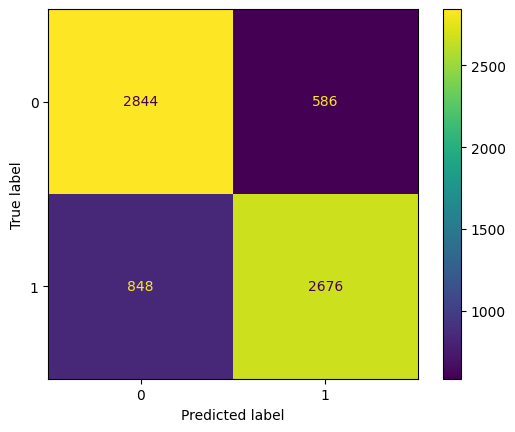

In [9]:
y_pred = cross_val_predict(et_best, X_train, y_train, cv=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
plt.show()

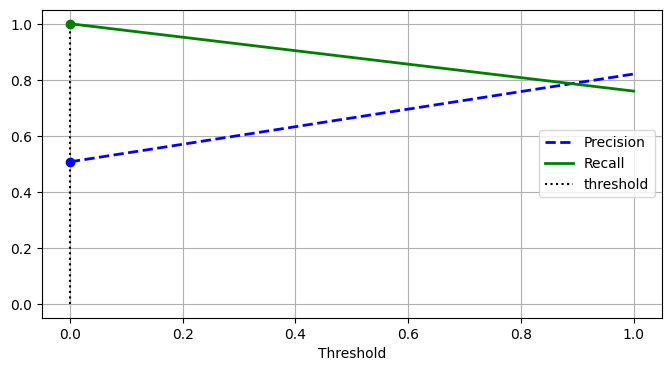

In [10]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

threshold = 0
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
# plt.axis([-1, 1, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

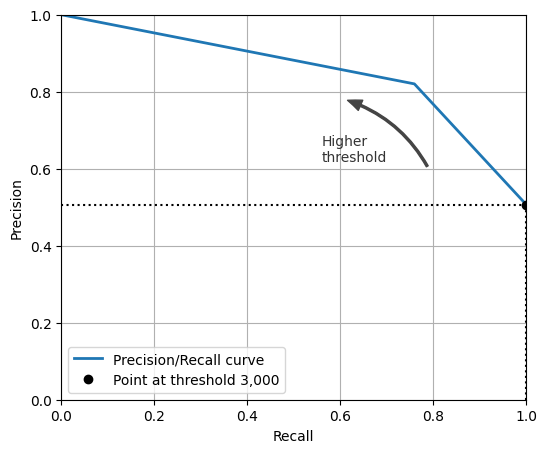

In [11]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [12]:
idx_for_90_precision = (precisions >= 0.50).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

y_train_pred_90 = (y_pred >= threshold_for_90_precision)

print(precision_score(y_train, y_train_pred_90))
recall_at_90_precision = recall_score(y_train, y_train_pred_90)
print(recall_at_90_precision)

0
0.5067587000287604
1.0


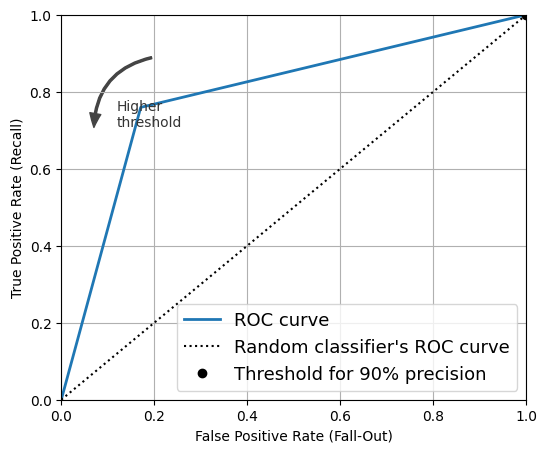

In [13]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [14]:
train_sizes, train_scores, valid_scores = learning_curve(
    et_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=10,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [ ]:
for score, name in zip(et_best.feature_importances_, X_train.columns):
    print(f"{score:.3f>20} {name.split('_')[1]:>20}")

In [ ]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    """convert log1p rmse to underlying SalePrice error"""
    # MEAN_RESPONSE assumes folds have same mean response, which is true in expectation but not in each fold
    # we can also pass the mean response for each fold
    # but we're really just looking to consistently convert the log value to a more meaningful unit
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
lr = LinearRegression()
# compute CV metric for each fold
scores = -cross_val_score(et_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

In [ ]:
elasticnetcv = make_pipeline(RobustScaler(),
                             ElasticNetCV(max_iter=100000, 
                                          l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                          alphas=np.logspace(-4, -2, 9),
                                          cv=kfolds,
                                          n_jobs=-1,
                                          verbose=1,
                                         ))

#train and get hyperparams
elasticnetcv.fit(X_train, y_train)
l1_ratio = elasticnetcv._final_estimator.l1_ratio_
alpha = elasticnetcv._final_estimator.alpha_
print('l1_ratio', l1_ratio)
print('alpha', alpha)

# evaluate using kfolds on full dataset
# I don't see API to get CV error from elasticnetcv, so we use cross_val_score
elasticnet = ElasticNet(alpha=alpha,
                        l1_ratio=l1_ratio,
                        max_iter=10000)

scores = -cross_val_score(elasticnet, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))
# l1_ratio 0.01
# alpha 0.0031622776601683794

# Log1p CV RMSE 0.1030 (STD 0.0109)
# Raw CV RMSE 18061 (STD 2008)
# CPU times: user 5.93 s, sys: 3.67 s, total: 9.6 s
# Wall time: 1.61 s

In [ ]:
PARAMETERS = {'booster' : ['gbtree', "dart"],
              'gamma': [1, 5,],
              'eta': [0.05],
              'learning_rate': [0.05,0.1],
              "subsample": [1], 
              'max_depth': [8, 10],
              'n_estimators': [600, 1000],
              "colsample_bytree": [0.5,0.88],
              "scale_pos_weight": [1,],
              'reg_alpha': [0,1],
              'reg_lambda': [2,],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=lgb.LGBMClassifer(),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

lbg_best = grid_search_xgb.best_estimator_
print("LGBM Classifer")
print('LGBM Classifer Best Score',grid_search_xgb.best_score_)
print('LGBM Classifer Best Parmas',grid_search_xgb.best_params_)
print('LGBM Classifer Accuracy',cross_val_score(lbg_best,X_train.values, y_train.values.ravel(), cv=10).mean())

In [ ]:
model = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2, eval_metric='logloss', eval_set=evalset)

In [ ]:
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

In [ ]:
# retrieve performance metrics
results = model.evals_result()

In [ ]:
X_train.head()

In [ ]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='training')
plt.plot(results['validation_1']['logloss'], label='valid0')

# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
import lightgbm as lgb
regr = lgb.LGBMClassifier()
regr.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
model = lgb.LGBMClassifier()
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2)

In [ ]:
y_hat = model.predict(X_test)
score = accuracy_score(y_test, yhat)

In [ ]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

In [ ]:
results = model.evals_result()

In [ ]:
results

In [ ]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='training')
plt.plot(results['validation_1']['logloss'], label='valid_0')
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Logloss")
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
import sklearn.datasets, sklearn.model_selection

X, y = sklearn.datasets.load_boston(return_X_y=True)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=7054)

model = model = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)

xgb.plot_metric(model)

In [ ]:
sns.lineplot(results['validation_0']['logloss'], label='training')
sns.lineplot(results['validation_1']['logloss'], label='valid_0')
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Logloss")
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
import lightgbm as lgb
import sklearn.datasets, sklearn.model_selection
X, y = sklearn.datasets.load_boston(return_X_y=True)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=7054)

model = lgb.LGBMRegressor(objective='mse', seed=42, num_threads=1, num_iterations=500)
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)

lgb.plot_metric(model)

In [ ]:


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    return plt


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (XGBoosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

estimator = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

title = r"Learning Curves (LGBMClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = lgb.LGBMClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Poly SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

estimator = SVC(kernel="poly", degree=7, C=11)
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

title = r"Learning Curves (ExtraTreeClassifer)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = ExtraTreesClassifier(max_features="sqrt", n_estimators=750)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [ ]:
perm = PermutationImportance(grid_search_xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
pred = grid_search_xgb.predict(X_test)
print(classification_report(y_test, pred, target_names=["0","1"]))
plot_roc_curve(grid_search_xgb, X_test, y_test)

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y = pandas_preprocessing(data1)

data1 = preprocessing.fit_transform(data1)
data2 = preprocessing.transform(data2)

pred = grid_search_xgb.predict(data2)
pred = pred.astype(bool)

result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)